In [59]:
from __future__ import print_function
from __future__ import division
import os
import os.path as path
import cv2
import numpy as np
import argparse
import skimage.io as io
# import os.path as path
import matplotlib.pyplot as plt



import imageio
imageio.plugins.freeimage.download()
from TMQI import TMQI
# #pip install PyContracts
# from optparse import OptionParser
# # from scipy.misc import imsave
# from imageio import imread
# import os.path
# # import wget
# import skimage.color

Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%475136/4830080 bytes (9.8%1253376/4830080 bytes (25.9%2301952/4830080 bytes (47.7%3391488/4830080 bytes (70.2%4358144/4830080 bytes (90.2%4830080/4830080 bytes (100.0%)
  Done
File saved as /home/elim/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.


In [2]:
def loadExposureSeq(path):
    images = []
    times = []
    with open(os.path.join(path, 'list.txt')) as f:
        content = f.readlines()
        

    for line in content:
        tokens = line.split()
        images.append(cv2.imread(os.path.join(path, tokens[0])))
        times.append(1/float(tokens[1]))
        
    return images, np.asarray(times, dtype=np.float32)

TonemapDrago 
Adaptive logarithmic mapping is a fast global tonemapping algorithm that scales the image in logarithmic domain.
Since it's a global operator the same function is applied to all the pixels, it is controlled by the bias parameter.

TonemapMantiuk 
This algorithm transforms image to contrast using gradients on all levels of gaussian pyramid, transforms contrast values to HVS response and scales the response. After this the image is reconstructed from new contrast values.

Tonemap Reinhard
This is a global tonemapping operator that models human visual system.


TonemapDurand
This algorithm decomposes image into two layers: base layer and detail layer using bilateral filter and compresses contrast of the base layer thus preserving all the details.

In [192]:
# path1 = './images/hdr-data/'
# images, times = loadExposureSeq(path1)
# calibrate = cv2.createCalibrateDebevec()
# response = calibrate.process(images, times)

# # Merge exposures to HDR image
# merge_debevec = cv2.createMergeDebevec()
# hdr= merge_debevec.process(images, times=times)
filename = "./images/hdr-data/Arches_E_PineTree_3k.hdr"
hdr = imageio.imread(filename,format='HDR')

sz = (int(hdr.shape[1]/2),int(hdr.shape[0]/2))
hdr = cv2.resize(hdr, sz)

# Tonemap HDR image with different algo
tonemap1 = cv2.createTonemapDrago(gamma=2.2, saturation=1)
td_ldr = tonemap1.process(hdr.copy())

tonemap1 = cv2.createTonemapMantiuk(gamma=2.2, saturation=0.9, scale=0.7)
tm_ldr = tonemap1.process(hdr.copy())

tonemap1 = cv2.createTonemapReinhard(gamma=2.2, intensity=0, light_adapt=0.8, color_adapt=0)
tr_ldr = tonemap1.process(hdr.copy())

tonemap1 = cv2.createTonemapDurand(gamma=2.2)
tdu_ldr = tonemap1.process(hdr.copy())

In [193]:
def showHDR(ldr, filename):
    im2_8bit = np.clip(ldr * 255, 0, 255).astype('uint8')
    new_filename = filename + ".png"
    io.imsave(new_filename, im2_8bit)
    
showHDR(td_ldr, "./images/hdr-results/ldr-td")
showHDR(tm_ldr, "./images/hdr-results/ldr-tm")
showHDR(tr_ldr, "./images/hdr-results/ldr-tr")
showHDR(tdu_ldr, "./images/hdr-results/ldr-tdu")

In [194]:
td_ldr.shape

(800, 1600, 3)

In [195]:
hdr.shape

(800, 1600, 3)

In [196]:
def tm_index(hdr_img,ldr_img):
    r1 = hdr_img
    r2 = ldr_img
    a = TMQI.TMQI()(np.nan_to_num(r1,0),np.nan_to_num(r2,0))
    #Quality Assessment Model, StructuralFidelity, Statistical Naturalness
    print(
        f"TMQI \n Q: {np.round(a[0],8)},\
        S: {np.round(a[1],8)},\
        N: {a[2]}")
    
tm_index(hdr,td_ldr)
tm_index(hdr,tm_ldr)
tm_index(hdr,tr_ldr)
tm_index(hdr,tdu_ldr)

TMQI 
 Q: 0.21171588,        S: 0.01266107,        N: 4.2891677590540357e-13
TMQI 
 Q: 0.21049821,        S: 0.01242357,        N: 1.0220895938531042e-13
TMQI 
 Q: 0.21111508,        S: 0.0125435,        N: 6.863070023460772e-13
TMQI 
 Q: 0.2103831,        S: 0.01240128,        N: 4.156258135267239e-13


## OpenEXR

In [ ]:
import OpenEXR
import sys
import array
import OpenEXR
import Imath

In [71]:
# if len(sys.argv) != 3:
#     print ("usage: exrnormalize.py exr-input-file exr-output-file")
#     sys.exit(1)

# Open the input file
file = OpenEXR.InputFile("./images/hdr-data/Iwate.exr")

# Compute the size
dw = file.header()['dataWindow']
sz = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

# Read the three color channels as 32-bit floats
FLOAT = Imath.PixelType(Imath.PixelType.FLOAT)
(R,G,B) = [array.array('f', file.channel(Chan, FLOAT)).tolist() for Chan in ("R", "G", "B") ]

# Normalize so that brightest sample is 1
brightest = max(R + G + B)
R = [ i / brightest for i in R ]
G = [ i / brightest for i in G ]
B = [ i / brightest for i in B ]

# Convert to strings
(Rs, Gs, Bs) = [ array.array('f', Chan).tobytes() for Chan in (R, G, B) ]

# Write the three color channels to the output file
out = OpenEXR.OutputFile("./images/hdr-results/hdr-out.exr", OpenEXR.Header(sz[0], sz[1]))
out.writePixels({'R' : Rs, 'G' : Gs, 'B' : Gs })

NameError: name 'OpenEXR' is not defined

## Colour-hdri

In [ ]:
import ipywidgets as widgets
import os
import colour

from colour_hdri import (
    EXAMPLES_RESOURCES_DIRECTORY,
    tonemapping_operator_simple,
    tonemapping_operator_normalisation,
    tonemapping_operator_gamma,
    tonemapping_operator_logarithmic,
    tonemapping_operator_exponential,
    tonemapping_operator_logarithmic_mapping,
    tonemapping_operator_exponentiation_mapping,
    tonemapping_operator_Schlick1994,
    tonemapping_operator_Tumblin1999,
    tonemapping_operator_Reinhard2004,
    tonemapping_operator_filmic)
from colour_hdri.plotting import plot_tonemapping_operator_image

RESOURCES_DIRECTORY = os.path.join(EXAMPLES_RESOURCES_DIRECTORY,
                                   'radiance')

colour.plotting.colour_style()

colour.utilities.describe_environment();

/home/elim/anaconda3/envs/graphics/lib/python3.6/site-packages/colour/utilities/verbose.py:237: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


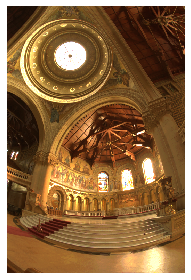

In [65]:
path2 = "./images/colour-hdri-examples-datasets/radiance/HDRMark_small.hdr" 
# path2 = "./images/hdr-data/memorial.hdr" 

HDRI_IMAGE = colour.read_image(path2)
HDRI_IMAGE = cv2.cvtColor(hdr_robertson, cv2.COLOR_BGR2RGB)
SAMPLES = np.linspace(0, 1, 512)
D_SAMPLES = np.dstack((SAMPLES, SAMPLES, SAMPLES))

colour.plotting.plot_image(colour.cctf_encoding(HDRI_IMAGE));

In [ ]:
plot_tonemapping_operator_image(
    tonemapping_operator_simple(HDRI_IMAGE),
    tonemapping_operator_simple(SAMPLES),
    title='Simple Tonemapping Operator');

In [ ]:
gamma=1.2
f_stop=0
ldr = plot_tonemapping_operator_image(
    tonemapping_operator_gamma(HDRI_IMAGE, gamma, f_stop),
    tonemapping_operator_gamma(SAMPLES, gamma, f_stop),
    title='Gamma Tonemapping Operator');

In [ ]:
def tonemapping_operator_gamma_interactive(image, gamma=1, f_stop=0):
    plot_tonemapping_operator_image(
        tonemapping_operator_gamma(image, gamma, f_stop),
        tonemapping_operator_gamma(SAMPLES, gamma, f_stop),
        title='Gamma Tonemapping Operator')


widgets.interactive(
    tonemapping_operator_gamma_interactive,
    image=widgets.fixed(HDRI_IMAGE),
    gamma=(0.1, 3, 0.1),
    f_stop=(-10, 10, 0.1))

In [ ]:
def tonemapping_operator_gamma_interactive(image, gamma=1, f_stop=0):
    plot_tonemapping_operator_image(
        tonemapping_operator_gamma(image, gamma, f_stop),
        tonemapping_operator_gamma(SAMPLES, gamma, f_stop),
        title='Gamma Tonemapping Operator')


widgets.interactive(
    tonemapping_operator_gamma_interactive,
    image=widgets.fixed(HDRI_IMAGE),
    gamma=(0.1, 3, 0.1),
    f_stop=(-10, 10, 0.1))